## Data Summary Notebook

In this notebook we seek to extract data from the Platynereis Larva Dumerilii Connectome and categorize the data in a way that will allow us to easily plot meaningful statistics of the dataset

In [13]:
import pymaid
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import logging
import collections
from itertools import chain, combinations

We start by first using pymaid to extract the dataset

In [3]:
rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()
path = "/Users/kareefullah/Desktop/neurodata/neurodata/platy-data/docs/outputs"

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


The following function takes in a list of annotations that the cells could be annotated with, and returns a pandas series: indices represent the skeleton ids of all the cells that have one of the annotations in the annotation list, and the values are an indicator of the annotion the respective cell has

The annot_lists that are allowed are:  
side: `["left", "right", "center"]`  
class: `["Sensory neuron", "interneuron", "motorneuron"]`  
segment: `["segment_0", "segment_1", "segment_2", "segment_3", "head", "pygidium"]`    
type: `["celltype1", "celltype2", ... "celltype180"]`    
group: `["cellgroup1", "cellgroup2", ... "cellgroup18"]`  

category can be `"side"` or `"class"` or `"segment"` or `"type"` or `"group"`

In [4]:
def get_labels_from_annotation(annot_list, category="side"):
    all_ids = pymaid.get_skids_by_annotation(annot_list)
    id_annot = []

    if category == "type" or category == "group":
        for annot in annot_list:
            ids = pymaid.get_skids_by_annotation(annot)
            for id in ids:
                if id in all_ids:
                    all_ids.remove(id)
                    if category == "type":
                        label = annot.split("celltype")[1]
                    else:
                        label = annot.split("cellgroup")[1]
                    id_annot.append([id, label])

    # power set of annot_list reversed: first look at the intersections within annot_list then singular entries
    elif category == "side" or category == "class" or category == "segment":
        annot_power = list(
            chain.from_iterable(
                combinations(annot_list, r) for r in range(len(annot_list) + 1)
            )
        )
        annot_power.reverse()

        for annots in annot_power:

            # skip the empty set in the power set
            if len(annots) != 0:
                ids = pymaid.get_skids_by_annotation(annots, intersect=True)

                # assign label to every id
                for id in ids:
                    if id in all_ids:
                        # make sure cannot find id again if it is already added to id_list
                        all_ids.remove(id)
                        label = ""
                        for annot in annots:
                            if category == "side":
                                label += annot[0]
                            elif category == "class":
                                label += annot[0].lower()
                            elif category == "segment":
                                if annot[0] == "s":
                                    label += annot[-1]
                                else:
                                    label += annot
                            else:
                                raise ValueError("category is invalid")
                        id_annot.append([id, label])

    else:
        raise ValueError("category is invalid")

    id_annot = np.array(id_annot)

    ids = id_annot[:, 0]
    annots = id_annot[:, 1]
    return pd.Series(index=ids, data=annots, name=category)


Here we make the table of annotations by making our annotation lists and making our pandas series for the five lists we have chosen. We then concatenate the series together to make a dataframe, which is our table.

In [38]:
side_list = ["left", "right", "center"]
class_list = ["Sensory neuron", "interneuron", "motorneuron"]
segment_list = ["segment_0", "segment_1", "segment_2", "segment_3", "head", "pygidium"]
type_list = []
for i in range(1, 181):
    type_list.append("celltype{}".format(i))

group_list = []
for j in range(1, 19):
    group_list.append("cellgroup{}".format(j))
    
side_labels = get_labels_from_annotation(side_list, category="side")
class_labels = get_labels_from_annotation(class_list, category="class")
segment_labels = get_labels_from_annotation(segment_list, category="segment")
type_labels = get_labels_from_annotation(type_list, category="type")
group_labels = get_labels_from_annotation(group_list, category="group")

series_ids = [side_labels, class_labels, segment_labels, type_labels, group_labels]
annotations = pd.concat(series_ids, axis=1, ignore_index=False, names="ID").fillna(
    "N/A"
)

Fetching:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching:   0%|          | 0/6 [00:00<?, ?it/s]

Fetching:   0%|          | 0/180 [00:00<?, ?it/s]

Fetching:   0%|          | 0/18 [00:00<?, ?it/s]

In [6]:
annotations

,side,class,segment,type,group
1343291,rc,N/A,head,N/A,N/A
1332516,rc,s,head,49,N/A
1402724,rc,N/A,3,N/A,N/A
1462664,rc,N/A,2,N/A,N/A
84457,rc,N/A,head,N/A,N/A
...,...,...,...,...,...
2256298,N/A,N/A,1,N/A,N/A
2256326,N/A,N/A,1,N/A,N/A
2256339,N/A,N/A,1,N/A,N/A
1602239,N/A,N/A,1,N/A,N/A


With this table of annotations, we can make barplots to plot the number of neurons for certain categories

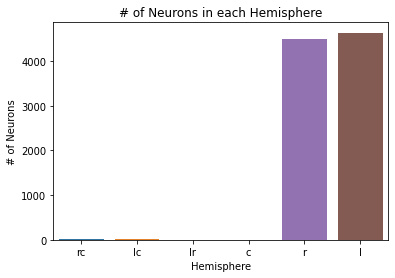

In [10]:
#print number of neurons in each hemisphere
hemis = {}
hemi_list = list(annotations["side"])
for i in range(len(hemi_list)):
    if hemi_list[i] == "N/A":
        continue
    
    if hemi_list[i] not in hemis:
        hemis[hemi_list[i]] = 1
    
    else:
        hemis[hemi_list[i]] += 1
sns.barplot(x=list(hemis.keys()), y=list(hemis.values())) 
plt.title("# of Neurons in each Hemisphere")
plt.xlabel("Hemisphere")
plt.ylabel("# of Neurons")
plt.savefig(path + "/neuron_count_hems")    
    

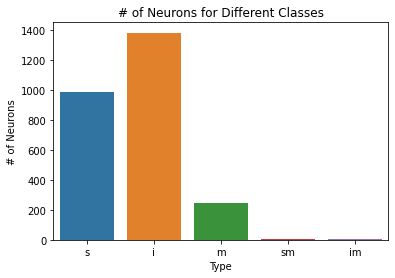

In [11]:
#print number of neurons for different types
classes = {}
class_list = list(annotations["class"])

for i in range(len(class_list)):
    if class_list[i] == "N/A":
        continue
    
    if class_list[i] not in classes:
        classes[class_list[i]] = 1
    
    else:
        classes[class_list[i]] += 1

sns.barplot(x=list(classes.keys()), y=list(classes.values())) 
plt.title("# of Neurons for Different Classes")
plt.xlabel("Type")
plt.ylabel("# of Neurons")
plt.savefig(path + "/neuron_count_classes")

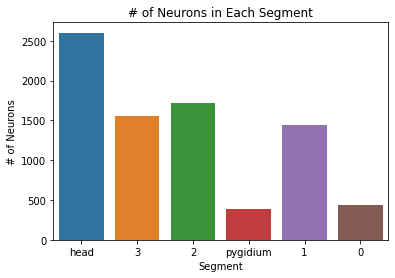

In [15]:
#print number of neurons in different segments
segments = {}
segment_list = list(annotations["segment"])

for i in range(len(segment_list)):
    if segment_list[i] == "N/A":
        continue
    
    if segment_list[i] not in segments:
        segments[segment_list[i]] = 1
    
    else:
        segments[segment_list[i]] += 1

sns.barplot(x=list(segments.keys()), y=list(segments.values())) 
plt.title("# of Neurons in Each Segment")
plt.xlabel("Segment")
plt.ylabel("# of Neurons")
plt.savefig(path + "/neuron_count_segments")

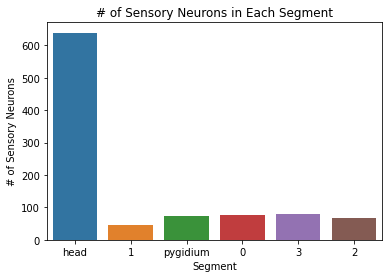

In [16]:
#print number of sensory neurons in each segment

indices = []
segment_sensory = {}
for i in range(len(class_list)):
    if(class_list[i] == "s"):
        indices.append(i)

for i in indices:
    if segment_list[i] == "N/A":
        continue
    
    if segment_list[i] not in segment_sensory:
        segment_sensory[segment_list[i]] = 1
    
    else:
        segment_sensory[segment_list[i]] += 1

sns.barplot(x=list(segment_sensory.keys()), y=list(segment_sensory.values())) 
plt.title("# of Sensory Neurons in Each Segment")
plt.xlabel("Segment")
plt.ylabel("# of Sensory Neurons")
plt.savefig(path + "/neuron_count_sensory_in_segments")

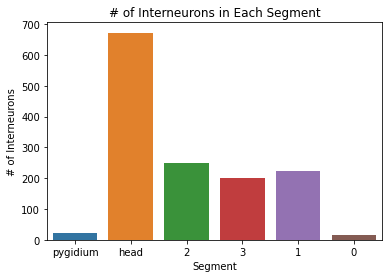

In [18]:
#print number of interneurons in each segment

indices = []
segment_inter = {}
for i in range(len(class_list)):
    if(class_list[i] == "i"):
        indices.append(i)

for i in indices:
    if segment_list[i] == "N/A":
        continue
    
    if segment_list[i] not in segment_inter:
        segment_inter[segment_list[i]] = 1
    
    else:
        segment_inter[segment_list[i]] += 1

sns.barplot(x=list(segment_inter.keys()), y=list(segment_inter.values())) 
plt.title("# of Interneurons in Each Segment")
plt.xlabel("Segment")
plt.ylabel("# of Interneurons")
plt.savefig(path + "/neuron_count_inter_in_segments")

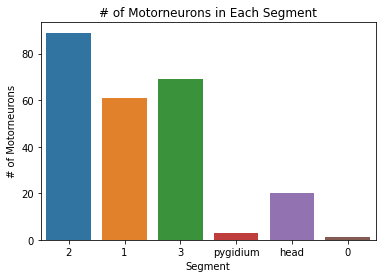

In [19]:
#print number of motorneurons in each segment

indices = []
segment_motor = {}
for i in range(len(class_list)):
    if(class_list[i] == "m"):
        indices.append(i)

for i in indices:
    if segment_list[i] == "N/A":
        continue
    
    if segment_list[i] not in segment_motor:
        segment_motor[segment_list[i]] = 1
    
    else:
        segment_motor[segment_list[i]] += 1
        
sns.barplot(x=list(segment_motor.keys()), y=list(segment_motor.values())) 
plt.title("# of Motorneurons in Each Segment")
plt.xlabel("Segment")
plt.ylabel("# of Motorneurons")
plt.savefig(path + "/neuron_count_motor_in_segments")

In [30]:
#number of neurons in each celltype (specified by paper)
celltype_count = {}
celltype_list = list(annotations["type"])
for i in range(len(celltype_list)):
    if celltype_list[i] == "N/A":
        continue
    
    if celltype_list[i] not in celltype_count:
        celltype_count[celltype_list[i]] = 1
    
    else:
        celltype_count[celltype_list[i]] += 1
celltype_count = {int(k):v for k,v in celltype_count.items()}
celltype_count = dict(sorted(celltype_count.items()))
df = pd.DataFrame.from_dict(celltype_count, orient="index", columns=["count"])
df = df.rename_axis('celltype', axis=1)
df.to_csv(path + "/neuron_count_neuronal_types.csv")
df

celltype,count
1,24
2,11
3,4
4,2
5,4
...,...
176,2
177,2
178,4
179,1


In [41]:
#number of neurons in each cellgroup (specified by paper)
cellgroup_count = {}
cellgroup_list = list(annotations["group"])
for i in range(len(cellgroup_list)):
    if cellgroup_list[i] == "N/A":
        continue
    if cellgroup_list[i] not in cellgroup_count:
        cellgroup_count[cellgroup_list[i]] = 1
    
    else:
        cellgroup_count[cellgroup_list[i]] += 1
cellgroup_count = {int(k):v for k,v in cellgroup_count.items()}
cellgroup_count = dict(sorted(cellgroup_count.items()))
df = pd.DataFrame.from_dict(cellgroup_count, orient="index", columns=["count"])
df = df.rename_axis('cellgroup', axis=1)
df.to_csv(path + "/neuron_count_groups.csv")
df

cellgroup,count
1,111
2,55
3,114
4,36
5,55
6,25
7,114
8,27
9,76
10,66


In [33]:
#number of cells in each non-neuronal celltype (TODO: make this a category in annotations?)
celltypes_non_neuronal = []
num_neurons = []
celltypes_non_neuronal_count = {}
for i, digit in enumerate(range(1, 91)):
   celltypes_non_neuronal.append("celltype_non_neuronal{}".format(str(digit)))
   num_neurons.append(len(pymaid.get_skids_by_annotation(celltypes_non_neuronal[i])))
   celltypes_non_neuronal_count[celltypes_non_neuronal[i]] = [num_neurons[i]]

df = pd.DataFrame.from_dict(celltypes_non_neuronal_count, orient="index", columns=["count"])
df.to_csv(path + "/neuron_count_non_neuronal_types")
print(df)

                         count
celltype_non_neuronal1       8
celltype_non_neuronal2       1
celltype_non_neuronal3      23
celltype_non_neuronal4       6
celltype_non_neuronal5       8
...                        ...
celltype_non_neuronal86      1
celltype_non_neuronal87      1
celltype_non_neuronal88      2
celltype_non_neuronal89      2
celltype_non_neuronal90   1079

[90 rows x 1 columns]
